In [1]:
import pandas as pd
import matplotlib as plt
import numpy as np
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import adfuller
from numpy import log
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import acf
from datetime import datetime, timedelta

In [2]:
#função para tratar campo data
def parser(x):
    return pd.datetime.strptime('190'+x, '%Y-%m')

#Agora vamos importar nosso arquivo 
df = pd.read_excel('biometria.xlsx', sheet_name='Página1')
print(df.head(10))

   Index   peso  comprimento_Total  comprimento_Padrao  comprimento_Cabeca  \
0    NaN  51.45               14.3                12.2                 4.0   
1    NaN  37.15               12.4                10.9                 3.8   
2    NaN  47.26               13.7                11.2                 3.4   
3    NaN  36.67               12.9                11.1                 3.7   
4    NaN  45.48               13.2                11.3                 3.8   
5    NaN  36.77               12.5                10.8                 3.2   
6    NaN  32.79               12.0                10.2                 3.4   
7    NaN  35.52               12.4                10.8                 3.4   
8    NaN  35.58               12.3                11.0                 3.4   
9    NaN  42.88               13.2                11.2                 3.8   

   altura  espessura       data  
0     4.1        1.9 2024-02-28  
1     3.2        1.2 2024-02-28  
2     4.0        1.7 2024-02-28  
3    

In [3]:
df1 = df.drop(columns=[
'data', 
'Index'
])
df1.head()

,peso,comprimento_Total,comprimento_Padrao,comprimento_Cabeca,altura,espessura
0,51.45,14.3,12.2,4.0,4.1,1.9
1,37.15,12.4,10.9,3.8,3.2,1.2
2,47.26,13.7,11.2,3.4,4.0,1.7
3,36.67,12.9,11.1,3.7,3.7,1.6
4,45.48,13.2,11.3,3.8,4.5,1.6


## Creating the unseen_Data of 10% of the real data to check model results

In [4]:
data = df1.sample(frac=0.9, random_state=123)
data_unseen = df1.drop(data.index)

data.reset_index(drop=True, inplace=True)
data_unseen.reset_index(drop=True, inplace=True)

print('Data for Modeling: ' + str(data.shape))
print('Unseen Data For Predictions: ' + str(data_unseen.shape))

Data for Modeling: (324, 6)
Unseen Data For Predictions: (36, 6)


In [5]:
for col in data.select_dtypes(include='number').columns:
    print(col)

peso
comprimento_Total
comprimento_Padrao
comprimento_Cabeca
altura
espessura


In [6]:
# Run this cel to make sure all the variable are type float64!
#data.info()

In [7]:
#from pycaret.datasets import get_data
#boston = get_data('boston')
from pycaret.regression import *
exp1 = setup(data = data,  target = 'peso', session_id=124, train_size=0.8, preprocess=False)


,Description,Value
0,Session id,124
1,Target,peso
2,Target type,Regression
3,Original data shape,"(324, 6)"
4,Transformed data shape,"(324, 6)"
5,Transformed train set shape,"(259, 6)"
6,Transformed test set shape,"(65, 6)"
7,Numeric features,5


In [8]:
best_model = compare_models(n_select=5 )  #sort= 'R2' TO select the metric R2

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
et,Extra Trees Regressor,3.9555,32.2475,5.6085,0.9781,0.0541,0.0443,0.0420
lightgbm,Light Gradient Boosting Machine,4.0623,33.3022,5.7009,0.9771,0.0597,0.0484,0.0570
rf,Random Forest Regressor,4.0761,34.9114,5.8244,0.9762,0.0573,0.0464,0.0550
ada,AdaBoost Regressor,4.4309,35.7626,5.9179,0.9757,0.0694,0.0568,0.0270
gbr,Gradient Boosting Regressor,4.3089,35.6378,5.8818,0.9757,0.0590,0.0495,0.0230
xgboost,Extreme Gradient Boosting,4.7050,42.1186,6.4036,0.9714,0.0635,0.0530,0.1220
lr,Linear Regression,5.4193,45.9921,6.6911,0.9688,0.1038,0.0767,0.6140
huber,Huber Regressor,5.3717,47.1706,6.7542,0.9686,0.0981,0.0739,0.0120
br,Bayesian Ridge,5.4455,46.4590,6.7420,0.9685,0.1034,0.0767,0.0080
ridge,Ridge Regression,5.4470,46.5333,6.7498,0.9684,0.1033,0.0766,0.0090


In [17]:
best_model

[ExtraTreesRegressor(n_jobs=-1, random_state=124),
 LGBMRegressor(n_jobs=-1, random_state=124),
 RandomForestRegressor(n_jobs=-1, random_state=124),
 AdaBoostRegressor(random_state=124),
 GradientBoostingRegressor(random_state=124)]

## Create Model
#### This function trains and evaluates the performance of a given estimator using cross validation. The output of this function is a score grid with CV scores by fold. Metrics evaluated during CV can be accessed using the get_metrics function. Custom metrics can be added or removed using add_metric and remove_metric function. All the available models can be accessed using the models function.

In [18]:
et = exp1.create_model('et')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,3.5927,26.6059,5.1581,0.9841,0.0475,0.0391
1,3.8995,28.2320,5.3134,0.9798,0.0484,0.0414
2,3.2000,21.3683,4.6226,0.9876,0.0501,0.0404
3,3.5507,24.8134,4.9813,0.9818,0.0518,0.0425
4,4.2133,31.4454,5.6076,0.9778,0.0570,0.0459
5,4.0540,48.8926,6.9923,0.9624,0.0638,0.0466
6,4.1429,40.7084,6.3803,0.9809,0.0534,0.0403
7,4.0781,33.8683,5.8196,0.9816,0.0550,0.0469
8,3.5603,17.9919,4.2417,0.9775,0.0523,0.0464


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

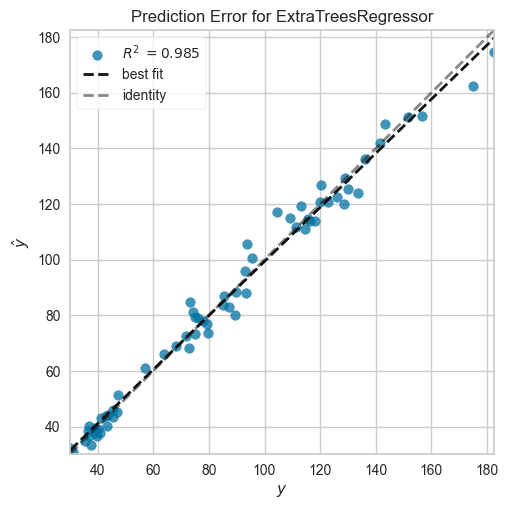

In [19]:
#plot_model(et, plot = 'residuals')
plot_model(et, plot = 'error')
#plot_model(et, plot = 'feature')



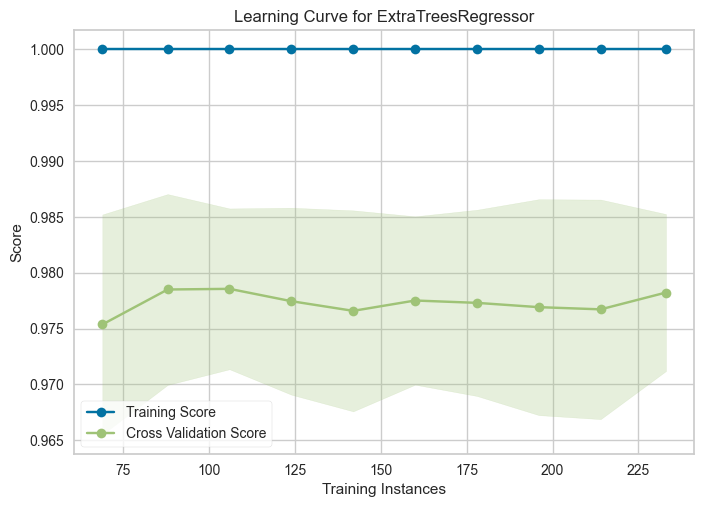

In [20]:
plot_model(et, plot = 'learning')

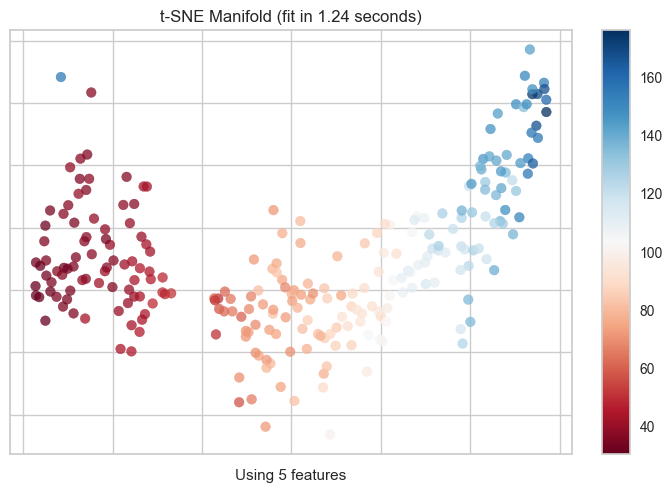

In [21]:
exp1.plot_model(et, plot = 'manifold')

## Blend an d sTacking if it is necessary!

In [22]:
holdout_pred = exp1.predict_model(et)
#holdout_pred.tail(5)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,3.6032,23.3468,4.8319,0.9849,0.0552,0.0444


In [23]:
unseen_predictions = exp1.predict_model(et, data=data_unseen)
unseen_predictions.head(5)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,3.2932,21.1352,4.5973,0.9836,0.0575,0.0452


,comprimento_Total,comprimento_Padrao,comprimento_Cabeca,altura,espessura,peso,prediction_label
0,13.7,11.2,3.4,4.0,1.7,47.259998,45.885600
1,12.7,10.8,3.3,3.7,1.6,37.130001,37.935500
2,13.0,11.0,3.3,4.2,1.8,46.599998,44.106000
3,11.8,9.9,3.2,3.5,1.5,30.740000,32.541001
4,12.2,10.3,3.1,3.6,1.6,33.959999,34.602500


## Tune model
#### This function tunes the hyperparameters of a given estimator. The output of this function is a score grid with CV scores by fold of the best selected model based on optimize parameter. Metrics evaluated during CV can be accessed using the get_metrics function. Custom metrics can be added or removed using add_metric and remove_metric function.

In [24]:
tune_et= exp1.tune_model(et)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,3.3554,28.9013,5.3760,0.9827,0.0483,0.0371
1,3.6916,26.4512,5.1431,0.9810,0.0484,0.0405
2,2.6688,15.6648,3.9579,0.9909,0.0468,0.0366
3,4.1030,28.7159,5.3587,0.9789,0.0595,0.0514
4,4.2935,26.8328,5.1800,0.9810,0.0549,0.0483
5,3.9159,57.3337,7.5719,0.9559,0.0667,0.0462
6,3.8162,31.3349,5.5978,0.9853,0.0532,0.0415
7,4.2755,33.3716,5.7768,0.9819,0.0565,0.0502
8,3.5328,18.6491,4.3185,0.9767,0.0545,0.0470


Fitting 10 folds for each of 10 candidates, totalling 100 fits


In [25]:
#plot_model(rf, plot = 'tree')

In [26]:
#pred_unseen = predict_model(rf, data = unseen_dataframe)


In [27]:
# dashboard of pycaret
#evaluate_model(rf)

# EXPERIMENT 2 
### Weight predicition using database from esalq esperiment without espessura feature.

#################################################### EXPERIMENT 2 #################################################33

In [9]:
df2 = df.drop(columns=[
'data', 
'Index',
'espessura'
])
df2.head()

,peso,comprimento_Total,comprimento_Padrao,comprimento_Cabeca,altura
0,51.45,14.3,12.2,4.0,4.1
1,37.15,12.4,10.9,3.8,3.2
2,47.26,13.7,11.2,3.4,4.0
3,36.67,12.9,11.1,3.7,3.7
4,45.48,13.2,11.3,3.8,4.5


In [10]:
data = df2.sample(frac=0.9, random_state=123)
data_unseen = df2.drop(data.index)

data.reset_index(drop=True, inplace=True)
data_unseen.reset_index(drop=True, inplace=True)

print('Data for Modeling: ' + str(data.shape))
print('Unseen Data For Predictions: ' + str(data_unseen.shape))

Data for Modeling: (324, 5)
Unseen Data For Predictions: (36, 5)


In [11]:
from pycaret.regression import *
exp2= setup(data = data,  target = 'peso')
best_model = exp2.compare_models()

,Description,Value
0,Session id,7139
1,Target,peso
2,Target type,Regression
3,Original data shape,"(324, 5)"
4,Transformed data shape,"(324, 5)"
5,Transformed train set shape,"(226, 5)"
6,Transformed test set shape,"(98, 5)"
7,Numeric features,4
8,Preprocess,True
9,Imputation type,simple


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
rf,Random Forest Regressor,4.0600,31.6096,5.5485,0.9771,0.0593,0.0487,0.0530
gbr,Gradient Boosting Regressor,4.2609,32.3687,5.6621,0.9770,0.0619,0.0514,0.0260
ada,AdaBoost Regressor,4.4619,37.1389,6.0548,0.9742,0.0710,0.0572,0.0310
et,Extra Trees Regressor,4.2764,37.4409,5.9241,0.9727,0.0623,0.0505,0.0410
xgboost,Extreme Gradient Boosting,4.6639,38.9182,6.2228,0.9724,0.0681,0.0569,0.0210
lightgbm,Light Gradient Boosting Machine,4.6543,44.9757,6.6108,0.9682,0.0656,0.0537,0.0380
br,Bayesian Ridge,5.4859,48.7693,6.9140,0.9655,0.1100,0.0791,0.0140
ridge,Ridge Regression,5.5892,51.0691,7.0679,0.9637,0.1113,0.0803,0.0100
llar,Lasso Least Angle Regression,5.7124,53.1971,7.2445,0.9630,0.1073,0.0802,0.0120
lasso,Lasso Regression,5.7124,53.1971,7.2445,0.9630,0.1073,0.0802,0.0150


In [13]:
rf = exp2.create_model('rf')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,3.6321,31.2497,5.5901,0.9806,0.0528,0.0413
1,4.2763,39.5584,6.2895,0.9534,0.0630,0.0508
2,4.1689,31.5230,5.6145,0.9818,0.0573,0.0460
3,5.5166,56.3391,7.5059,0.9563,0.0735,0.0603
4,4.2805,33.8638,5.8193,0.9788,0.0562,0.0475
5,4.2662,35.7581,5.9798,0.9787,0.0685,0.0553
6,3.0567,17.9646,4.2385,0.9886,0.0451,0.0369
7,4.0568,22.5276,4.7463,0.9847,0.0652,0.0525
8,3.7927,27.1386,5.2095,0.9816,0.0615,0.0520


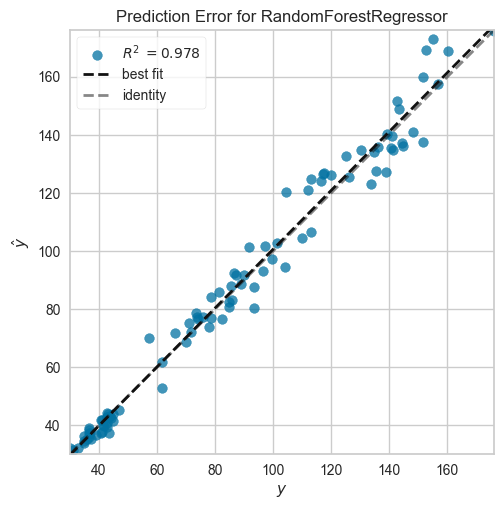

In [14]:
exp2.plot_model(rf, plot = 'error')

In [15]:
exp2.evaluate_model(rf)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

In [21]:
peso_pred_semEspe = exp2.predict_model(rf)
#peso_pred_semEspe.head(5)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Random Forest Regressor,4.4552,36.7836,6.0649,0.9783,0.0616,0.0501


In [22]:
pred_unseen = predict_model(rf, data = data_unseen)
pred_unseen.head(5)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Random Forest Regressor,3.0417,20.6230,4.5413,0.9840,0.0555,0.0411


,comprimento_Total,comprimento_Padrao,comprimento_Cabeca,altura,peso,prediction_label
0,13.7,11.2,3.4,4.0,47.259998,43.527500
1,12.7,10.8,3.3,3.7,37.130001,37.228599
2,13.0,11.0,3.3,4.2,46.599998,42.633700
3,11.8,9.9,3.2,3.5,30.740000,32.120600
4,12.2,10.3,3.1,3.6,33.959999,32.908400


In [ ]:
#tuned_gbr = tune_model(gbr)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,4.7974,39.0236,6.2469,0.9739,0.0576,0.0456
1,2.7883,14.7765,3.8440,0.9887,0.0520,0.0410
2,4.8336,41.1100,6.4117,0.9716,0.0620,0.0544
3,4.7503,38.9787,6.2433,0.9801,0.0600,0.0524
4,3.8073,27.0587,5.2018,0.9761,0.0642,0.0496
5,2.9277,16.8013,4.0989,0.9880,0.0495,0.0388
6,2.9499,18.5206,4.3036,0.9848,0.0476,0.0374
7,4.5485,36.9543,6.0790,0.9670,0.0627,0.0507
8,4.6366,43.4864,6.5944,0.9575,0.0646,0.0521


Fitting 10 folds for each of 10 candidates, totalling 100 fits


In [ ]:
#theta = exp.create_model('theta')
#exp.plot_model(plot = 'decomp',
#               data_kwargs = {'type' : 'multiplicative'},
#               fig_kwargs = {"height":500,"width":1000,"template": "simple_white","hoverinfo":"none","big_data_threshold":50})
#exp.plot_model(estimator = theta, plot = 'forecast', 
#               data_kwargs = {'fh' : 8},
#               fig_kwargs = {"height":500,"width":1000,"template": "simple_white","hoverinfo":"none","big_data_threshold":50})
#exp.predict_model(theta, fh = 8)

#### weight prediction 
#### Realizar um codigo padrao com avaliacao de modelos, tuning, evaluation, shuffle and save (retirar index)
#### realizar predicao para espessura
#### realizar a predicao do peso sem a variavel espessura